In [2]:
import os,sys
import datetime as dt
import xarray as xr
import time
import numpy as np
# np.set_printoptions(threshold=np.inf)
import seaborn as sns
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
import math
from datetime import datetime
import matplotlib.colors as mcolors
import matplotlib as mpl

In [7]:
# from skimage import measure
# from skimage import filters
import math
from mpl_toolkits.basemap import Basemap, cm
from datetime import datetime
import matplotlib.colors as mcolors
import matplotlib as mpl
%matplotlib inline

In [4]:
import meteva.base as meb      # 该模块用于IO和基础计算
import meteva.method as mem    # 该模块基础了检验的基础算法
import meteva.product as mpd   # 该模块包含了检验的工具
import numpy as np          
import datetime                      
import copy
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt

In [32]:
save_dir = '/p/scratch/deepacf/deeprain/ji4/Downsacling/results/swinUnet_exp1019_origin_booster_3years/prediction_18000'
model_name = 'swinUnet'
filename = 'prcp_downs_'+model_name+'.nc'
filepath = os.path.join(save_dir,filename)
with xr.open_dataset(filepath) as df:
    fcst = np.array(df['fcst'][:])
    refe = np.array(df['refe'][:])
    oupt = np.array(df['outputs'][:])
    inpt = np.array(df['inputs'][:])
    time = np.array(df['time'][:]) 
    print(df)

<xarray.Dataset>
Dimensions:    (time: 8924, lat: 160, lon: 160, lat_in: 16, lon_in: 16,
                pitch_idx: 8924)
Coordinates:
  * time       (time) datetime64[ns] 2020-10-11T10:00:00 ... 2020-10-06T20:00:00
  * pitch_idx  (pitch_idx) int32 3007 7854 7574 2604 ... 4487 6214 7812 1618
Dimensions without coordinates: lat, lon, lat_in, lon_in
Data variables:
    outputs    (time, lat, lon) float32 ...
    fcst       (time, lat, lon) float32 ...
    refe       (time, lat, lon) float32 ...
    inputs     (time, lat_in, lon_in) float32 ...
Attributes:
    description:  Precipitation downscaling data.


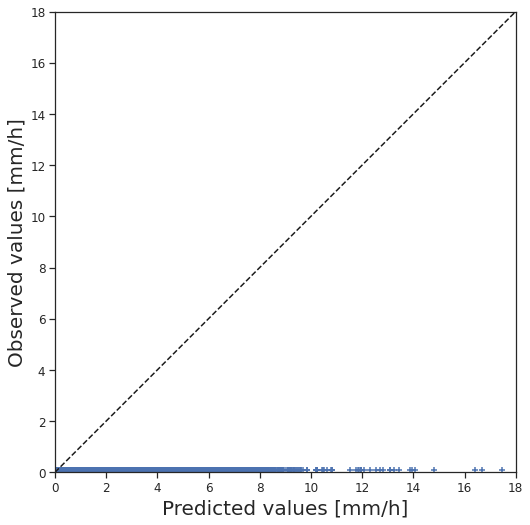

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
plt.scatter(refe[:,::10,::10].flatten(),fcst[:,::10,::10].flatten(),marker='+')

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.title('threshold: '+threshold+'mm', fontsize=14,loc='center',pad=6)
# legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),

ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")

ax.set_xlim([0, 18])
ax.set_ylim([0, 18])
ax.set_xlabel("Predicted values [mm/h]",fontsize=20)
ax.set_ylabel("Observed values [mm/h]",fontsize=20)

figname = model_name+'_scatters'
figpath = os.path.join(save_dir,figname)
plt.savefig(figpath, bbox_inches="tight")
plt.show()

In [22]:
grade_list = [0.1,5,10,20]
half_window_size_list = [3,5,10]

rmse = []
corr = []
pc = []
pc_of_sun_rain = []
pod = []
pofd = []
far = []
mr = []
bias = []
ts = []
ets = []
fscore = []
fss_middle = []
for i in range(refe.shape[0]):
    rmse.append(mem.rmse(refe[i],fcst[i]))
    corr.append(mem.corr(refe[i],fcst[i]))    
    pc.append(mem.pc(refe[i],fcst[i],grade_list=grade_list))
    pc_of_sun_rain.append(mem.pc_of_sun_rain(refe[i],fcst[i]))
    pod.append(mem.pod(refe[i],fcst[i],grade_list=grade_list))
    pofd.append(mem.pofd(refe[i],fcst[i],grade_list=grade_list))
    far.append(mem.far(refe[i],fcst[i],grade_list=grade_list))
    mr.append(mem.mr(refe[i],fcst[i],grade_list=grade_list))
    bias.append(mem.bias(refe[i],fcst[i],grade_list=grade_list))
    ts.append(mem.ts(refe[i],fcst[i],grade_list=grade_list))
    ets.append(mem.ets(refe[i],fcst[i],grade_list=grade_list))
    fscore.append(mem.fscore(refe[i],fcst[i],grade_list=grade_list))
    fss_middle.append(mem.fbs_pobfo(refe[i],fcst[i],grade_list=grade_list, 
                                    half_window_size_list=half_window_size_list))

rmse = np.stack(rmse)    
corr = np.stack(corr)    
pc = np.stack(pc)
pc_of_sun_rain = np.stack(pc_of_sun_rain)
pod = np.stack(pod)
pofd = np.stack(pofd)
far = np.stack(far)
mr = np.stack(mr)
bias = np.stack(bias)
ts = np.stack(ts)
ets = np.stack(ets)
fscore = np.stack(fscore)
fss_middle_all = np.stack(fss_middle)

fss = np.ones([refe.shape[0],len(grade_list),len(half_window_size_list)])
for k in range(refe.shape[0]):
    for i in range(len(grade_list)):
        for j in range(len(half_window_size_list)):
            fss[k,i,j] = 1 - fss_middle_all[k,j,i,2].sum()/(fss_middle_all[k,j,i,0].sum()+fss_middle_all[k,j,i,1].sum())

corr[np.where(corr>1)] = np.nan
pc[np.where(pc>1)] = np.nan
pc_of_sun_rain[np.where(pc_of_sun_rain>1)] = np.nan
pod[np.where(pod>1)] = np.nan
pofd[np.where(pofd>1)] = np.nan
far[np.where(far>1)] = np.nan
mr[np.where(mr>1)] = np.nan
ts[np.where(ts>1)] = np.nan
ets[np.where(ets>1)] = np.nan
fss[np.where(fss>1)] = np.nan
            

In [23]:
data = {'RMSE':  rmse,
        'CORR':  corr,
        'PC_of_sun_rain': pc_of_sun_rain,
        'TS0.1': ts[:,0],
        'TS5': ts[:,1],
#         'TS10': ts[:,3],
        'ETS0.1': ets[:,0],
        'ETS5': ets[:,1],
#         'ETS10': ets[:,3],
        'FAR0.1': far[:,0],
        'FAR5': far[:,1],
#         'FAR10': far[:,3],
        'POM0.1': mr[:,0],
        'POM5': mr[:,1],
#         'POM10': mr[:,3],
        'FSS0.1': fss[:,0,1],
        'FSS5': fss[:,1,1],
#         'FSS10': fss[:,3,1],
       }
unet_all_vars = pd.DataFrame(data=data)

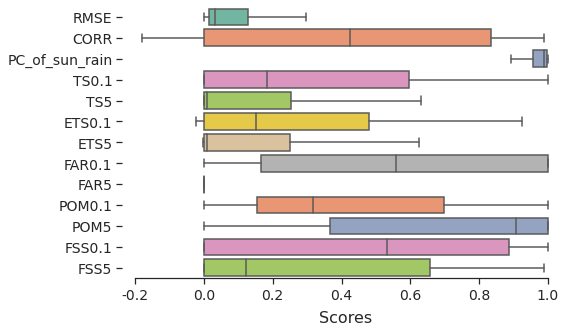

In [11]:
fig_path = os.path.join(save_dir,'unet_scores')
f, ax = plt.subplots(figsize=(8, 5))

sns.set_theme(style="ticks")
ax = sns.boxplot(data=unet_all_vars, orient="h",
                 palette="Set2", showfliers=False)
# ax.axhline(y=0, color="grey", linewidth=.5)
ax.set_xlabel('Scores', fontsize=16, labelpad=8)
# ax.set_ylabel('Continuous Ranked Probability Score', fontsize=14, labelpad=6)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(trim=True, left=True)
# plt.legend(title = "Model", 
#            fontsize = '10', title_fontsize = "10",
#            loc = 2, bbox_to_anchor = (1.01,0.7))
plt.savefig(fig_path, bbox_inches="tight")
plt.show()
plt.close()

In [12]:
# create colormaps
clevs = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750])*1e-2
label = 'Precipitation Rate [mm/hour]'
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]

cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
cmap.set_bad(color='grey')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

In [13]:
def spatial_plot(prcp,title,figname):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])

    if '_in' in title:
        dx, dy = 1, 1
    else:
        dx, dy = 0.1, 0.1
    y, x = np.mgrid[slice(-8, 8+dy, dy),
                slice(-8, 8+dx, dx)]

    cs = plt.pcolormesh(x,y,prcp,cmap=cmap,norm=norm,vmin=0.)
    plt.yticks(np.arange(-8,10,2),fontsize=18)
    plt.xticks(np.arange(-8,10,2),fontsize=18)

    # # add colorbar.
    label = 'Precipitation rate [mm/h]'    
    cbar = plt.colorbar(cs,location='right',pad=0.03)
    cbar.set_label(label,fontsize=20) # 10$\mathregular{^-}$$\mathregular{^1}$ 
    
    plt.title(title, fontsize=20,loc='center',pad=6)

    # save to disk
    plt.savefig(figname, bbox_inches="tight")
    plt.show()

In [14]:
iet = np.where(np.nansum(refe,(1,2))==np.nanmax(np.nansum(refe,(1,2))))[0][0]

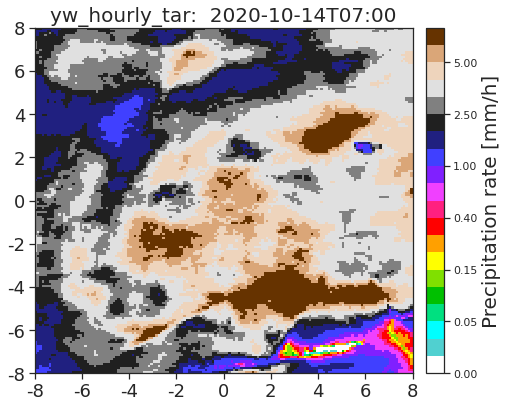

In [16]:
prcp = refe[iet]
tim = str(time[iet])[:16]
title = "yw_hourly_tar:  "+tim
figname = "yw_hourly_tar_"+tim
figpath = os.path.join(save_dir,figname)
spatial_plot(prcp,title,figpath)


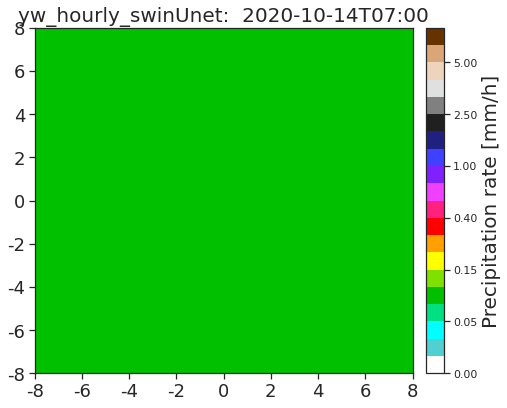

In [34]:
prcp = fcst[iet]
title = "yw_hourly_"+model_name+":  "+tim
figname = "yw_hourly_"+model_name+"_"+tim
figpath = os.path.join(save_dir,figname)
spatial_plot(prcp,title,figpath)


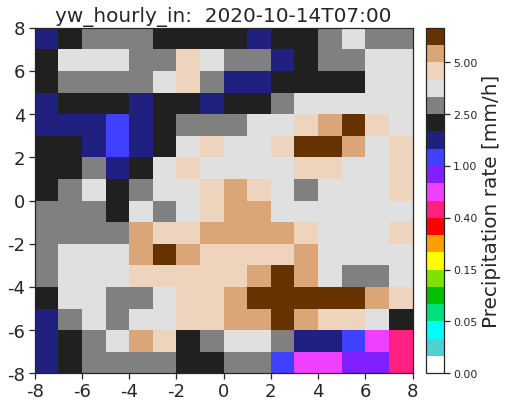

In [18]:
prcp = inpt[iet]
title = "yw_hourly_in:  "+tim
figname = "yw_hourly_in_"+tim
figpath = os.path.join(save_dir,figname)
spatial_plot(prcp,title,figpath)
